# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

In [2]:
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import CIFAR10

class CustomDataset(Dataset):
    """
    Custom Dataset Class
    """
    def __init__(self, dataset, transforms=None):
        """Initialize Dataset
        Args:
            dataset (Dataset): Pytorch Dataset instance
            transforms (Transform.Compose, optional): Tranform function instance. Defaults to None.
        """
        self.transforms = transforms
        self.dataset = dataset

    def __len__(self):
        """Get dataset length
        Returns:
            int: Length of dataset
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """Get an item form dataset
        Args:
            idx (int): id of item in dataset
        Returns:
            (tensor, int): Return tensor of transformer image, label
        """
        # Read Image and Label
        image, label = self.dataset[idx]
        image = np.array(image)

        # Apply Transforms
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]

        return (image, label)


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [7]:
# Train Phase transformations
# Define the Albumentations transformations
train_transforms = A.Compose([
    A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
    A.PadIfNeeded(min_height=40,min_width=40),
    A.RandomCrop(32, 32, p=1.0),
    A.HorizontalFlip(),
    A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=[0.4914, 0.4822, 0.4465], always_apply=False, p=0.1),
    ToTensorV2(),
])

# Test Phase transformations
test_transforms = A.Compose([
    A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
    ToTensorV2()
])


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# Dataset and Creating Train/Test Split

In [8]:
train_set = CustomDataset(
            datasets.CIFAR10("./data", train=True, download=True),
            transforms=train_transforms,
        )
test_set = CustomDataset(
            datasets.CIFAR10("./data", train=False, download=True),
            transforms=train_transforms,
        )

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

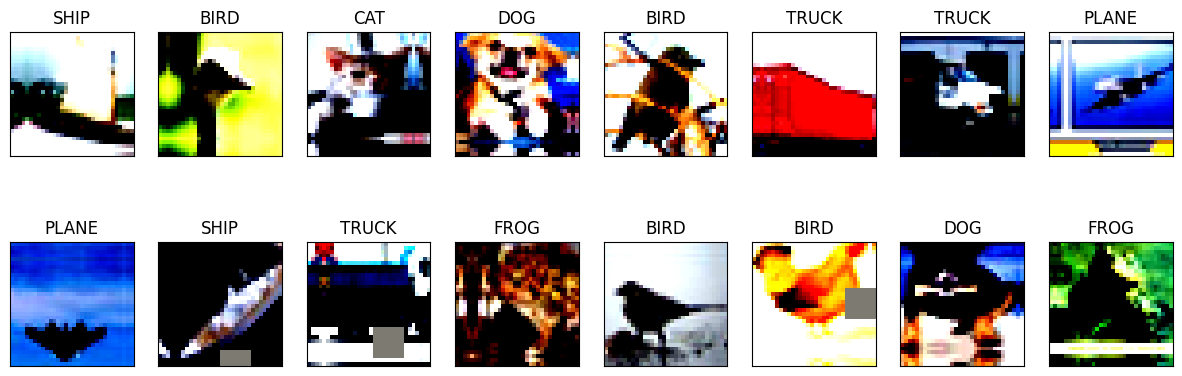

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import itertools
def print_samples(loader, class_map, count=16):
    """Print samples input images

    Args:
        loader (DataLoader): dataloader for training data
        count (int, optional): Number of samples to print. Defaults to 16.
    """
    # Print Random Samples
    if not count % 8 == 0:
        return

    classes = list(class_map.keys())
    fig = plt.figure(figsize=(15, 5))
    for imgs, labels in loader:
        for i in range(count):
            ax = fig.add_subplot(int(count / 8), 8, i + 1, xticks=[], yticks=[])
            ax.set_title(f"{classes[labels[i]]}")
            plt.imshow(imgs[i].cpu().numpy().transpose(1, 2, 0).astype(float))
        break
class_map = {
    "PLANE": 0,
    "CAR": 1,
    "BIRD": 2,
    "CAT": 3,
    "DEER": 4,
    "DOG": 5,
    "FROG": 6,
    "HORSE": 7,
    "SHIP": 8,
    "TRUCK": 9,
}

print_samples(train_loader, class_map)

# The model
Let's start with the model we first saw

In [11]:
from model import CustomResNet

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [14]:
!pip install torch-lr-finder

## Finding LR Max

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-02


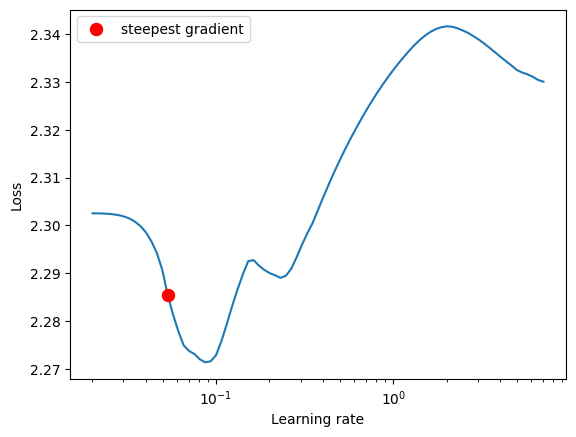

Best LR 0.08697490026177836


In [15]:
from torch_lr_finder import LRFinder

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=10, num_iter=100, step_mode="exp")

lr_finder.plot()
best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print('Best LR',best_lr)

In [16]:
lr_finder.reset()

In [17]:
lr_max= 5.34E-02
lr_min = 0.001
optimizer=optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=391*5 , step_size_down=391*15)


In [19]:
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    lr_scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=-0.7389600276947021 Batch_id=390 Accuracy=69.34: 100%|██████████| 391/391 [00:26<00:00, 14.69it/s]



Test set: Average loss: -0.6612, Accuracy: 6685/10000 (66.85%)

EPOCH: 1


Loss=-0.7107889652252197 Batch_id=390 Accuracy=69.76: 100%|██████████| 391/391 [00:26<00:00, 14.62it/s]



Test set: Average loss: -0.6647, Accuracy: 6709/10000 (67.09%)

EPOCH: 2


Loss=-0.6206892132759094 Batch_id=390 Accuracy=70.19: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s]



Test set: Average loss: -0.6809, Accuracy: 6919/10000 (69.19%)

EPOCH: 3


Loss=-0.7633108496665955 Batch_id=390 Accuracy=73.18: 100%|██████████| 391/391 [00:26<00:00, 14.79it/s]



Test set: Average loss: -0.6998, Accuracy: 7102/10000 (71.02%)

EPOCH: 4


Loss=-0.7866025567054749 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s]



Test set: Average loss: -0.7101, Accuracy: 7201/10000 (72.01%)

EPOCH: 5


Loss=-0.7438679933547974 Batch_id=390 Accuracy=75.18: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s]



Test set: Average loss: -0.7156, Accuracy: 7257/10000 (72.57%)

EPOCH: 6


Loss=-0.6571382284164429 Batch_id=390 Accuracy=75.85: 100%|██████████| 391/391 [00:25<00:00, 15.26it/s]



Test set: Average loss: -0.7236, Accuracy: 7325/10000 (73.25%)

EPOCH: 7


Loss=-0.7576932311058044 Batch_id=390 Accuracy=76.40: 100%|██████████| 391/391 [00:25<00:00, 15.33it/s]



Test set: Average loss: -0.7309, Accuracy: 7394/10000 (73.94%)

EPOCH: 8


Loss=-0.8383808135986328 Batch_id=390 Accuracy=76.94: 100%|██████████| 391/391 [00:25<00:00, 15.08it/s]



Test set: Average loss: -0.7209, Accuracy: 7290/10000 (72.90%)

EPOCH: 9


Loss=-0.7055581212043762 Batch_id=390 Accuracy=77.33: 100%|██████████| 391/391 [00:25<00:00, 15.31it/s]



Test set: Average loss: -0.7338, Accuracy: 7424/10000 (74.24%)

EPOCH: 10


Loss=-0.749611496925354 Batch_id=390 Accuracy=77.73: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s]



Test set: Average loss: -0.7249, Accuracy: 7311/10000 (73.11%)

EPOCH: 11


Loss=-0.8085075616836548 Batch_id=390 Accuracy=78.18: 100%|██████████| 391/391 [00:26<00:00, 14.73it/s]



Test set: Average loss: -0.7385, Accuracy: 7444/10000 (74.44%)

EPOCH: 12


Loss=-0.7476736307144165 Batch_id=390 Accuracy=78.63: 100%|██████████| 391/391 [00:25<00:00, 15.17it/s]



Test set: Average loss: -0.7337, Accuracy: 7407/10000 (74.07%)

EPOCH: 13


Loss=-0.7708432078361511 Batch_id=390 Accuracy=78.93: 100%|██████████| 391/391 [00:24<00:00, 15.74it/s]



Test set: Average loss: -0.7442, Accuracy: 7506/10000 (75.06%)

EPOCH: 14


Loss=-0.7594772577285767 Batch_id=390 Accuracy=79.15: 100%|██████████| 391/391 [00:25<00:00, 15.64it/s]



Test set: Average loss: -0.7477, Accuracy: 7539/10000 (75.39%)

EPOCH: 15


Loss=-0.7984191179275513 Batch_id=390 Accuracy=79.66: 100%|██████████| 391/391 [00:25<00:00, 15.11it/s]



Test set: Average loss: -0.7397, Accuracy: 7462/10000 (74.62%)

EPOCH: 16


Loss=-0.8333936929702759 Batch_id=390 Accuracy=79.85: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s]



Test set: Average loss: -0.7436, Accuracy: 7494/10000 (74.94%)

EPOCH: 17


Loss=-0.7721295952796936 Batch_id=390 Accuracy=79.99: 100%|██████████| 391/391 [00:25<00:00, 15.49it/s]



Test set: Average loss: -0.7523, Accuracy: 7570/10000 (75.70%)

EPOCH: 18


Loss=-0.8184776306152344 Batch_id=390 Accuracy=80.34: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s]



Test set: Average loss: -0.7493, Accuracy: 7546/10000 (75.46%)

EPOCH: 19


Loss=-0.7825815677642822 Batch_id=390 Accuracy=80.59: 100%|██████████| 391/391 [00:25<00:00, 15.64it/s]



Test set: Average loss: -0.7511, Accuracy: 7574/10000 (75.74%)

EPOCH: 20


Loss=-0.7235853672027588 Batch_id=390 Accuracy=80.94: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s]



Test set: Average loss: -0.7538, Accuracy: 7589/10000 (75.89%)

EPOCH: 21


Loss=-0.8276389241218567 Batch_id=390 Accuracy=81.05: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s]



Test set: Average loss: -0.7613, Accuracy: 7668/10000 (76.68%)

EPOCH: 22


Loss=-0.7769805192947388 Batch_id=390 Accuracy=81.29: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s]



Test set: Average loss: -0.7599, Accuracy: 7646/10000 (76.46%)

EPOCH: 23


Loss=-0.7154543995857239 Batch_id=390 Accuracy=81.39: 100%|██████████| 391/391 [00:25<00:00, 15.41it/s]



Test set: Average loss: -0.7649, Accuracy: 7713/10000 (77.13%)

EPOCH: 24


Loss=-0.7928584814071655 Batch_id=390 Accuracy=81.47: 100%|██████████| 391/391 [00:25<00:00, 15.41it/s]



Test set: Average loss: -0.7677, Accuracy: 7736/10000 (77.36%)

EPOCH: 25


Loss=-0.8659998774528503 Batch_id=390 Accuracy=81.93: 100%|██████████| 391/391 [00:26<00:00, 14.94it/s]



Test set: Average loss: -0.7661, Accuracy: 7721/10000 (77.21%)

EPOCH: 26


Loss=-0.7034163475036621 Batch_id=390 Accuracy=82.02: 100%|██████████| 391/391 [00:24<00:00, 16.03it/s]



Test set: Average loss: -0.7570, Accuracy: 7606/10000 (76.06%)

EPOCH: 27


Loss=-0.8797570466995239 Batch_id=390 Accuracy=82.25: 100%|██████████| 391/391 [00:24<00:00, 16.20it/s]



Test set: Average loss: -0.7670, Accuracy: 7728/10000 (77.28%)

EPOCH: 28


Loss=-0.8390817642211914 Batch_id=390 Accuracy=82.67: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]



Test set: Average loss: -0.7675, Accuracy: 7725/10000 (77.25%)

EPOCH: 29


Loss=-0.8599830865859985 Batch_id=390 Accuracy=82.45: 100%|██████████| 391/391 [00:24<00:00, 15.71it/s]



Test set: Average loss: -0.7644, Accuracy: 7698/10000 (76.98%)

EPOCH: 30


Loss=-0.9080682992935181 Batch_id=390 Accuracy=82.85: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]



Test set: Average loss: -0.7652, Accuracy: 7697/10000 (76.97%)

EPOCH: 31


Loss=-0.8512714505195618 Batch_id=390 Accuracy=82.90: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s]



Test set: Average loss: -0.7673, Accuracy: 7730/10000 (77.30%)

EPOCH: 32


Loss=-0.7900488376617432 Batch_id=390 Accuracy=83.11: 100%|██████████| 391/391 [00:26<00:00, 15.01it/s]



Test set: Average loss: -0.7753, Accuracy: 7807/10000 (78.07%)

EPOCH: 33


Loss=-0.8320744633674622 Batch_id=390 Accuracy=83.20: 100%|██████████| 391/391 [00:25<00:00, 15.64it/s]



Test set: Average loss: -0.7673, Accuracy: 7712/10000 (77.12%)

EPOCH: 34


Loss=-0.9007150530815125 Batch_id=390 Accuracy=83.38: 100%|██████████| 391/391 [00:24<00:00, 15.71it/s]



Test set: Average loss: -0.7584, Accuracy: 7619/10000 (76.19%)

EPOCH: 35


Loss=-0.6846899390220642 Batch_id=390 Accuracy=83.48: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s]



Test set: Average loss: -0.7699, Accuracy: 7752/10000 (77.52%)

EPOCH: 36


Loss=-0.8914202451705933 Batch_id=390 Accuracy=83.72: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s]



Test set: Average loss: -0.7715, Accuracy: 7765/10000 (77.65%)

EPOCH: 37


Loss=-0.8624817132949829 Batch_id=390 Accuracy=83.88: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s]



Test set: Average loss: -0.7745, Accuracy: 7783/10000 (77.83%)

EPOCH: 38


Loss=-0.8644660115242004 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [00:24<00:00, 15.68it/s]



Test set: Average loss: -0.7730, Accuracy: 7777/10000 (77.77%)

EPOCH: 39


Loss=-0.8264861106872559 Batch_id=390 Accuracy=84.15: 100%|██████████| 391/391 [00:26<00:00, 14.70it/s]



Test set: Average loss: -0.7736, Accuracy: 7774/10000 (77.74%)

EPOCH: 40


Loss=-0.7361206412315369 Batch_id=390 Accuracy=84.13: 100%|██████████| 391/391 [00:25<00:00, 15.22it/s]



Test set: Average loss: -0.7725, Accuracy: 7760/10000 (77.60%)

EPOCH: 41


Loss=-0.8082645535469055 Batch_id=390 Accuracy=84.47: 100%|██████████| 391/391 [00:25<00:00, 15.26it/s]



Test set: Average loss: -0.7823, Accuracy: 7881/10000 (78.81%)

EPOCH: 42


Loss=-0.8625292778015137 Batch_id=390 Accuracy=84.62: 100%|██████████| 391/391 [00:25<00:00, 15.15it/s]



Test set: Average loss: -0.7719, Accuracy: 7759/10000 (77.59%)

EPOCH: 43


Loss=-0.7751172780990601 Batch_id=390 Accuracy=84.64: 100%|██████████| 391/391 [00:25<00:00, 15.12it/s]



Test set: Average loss: -0.7797, Accuracy: 7842/10000 (78.42%)

EPOCH: 44


Loss=-0.7496389150619507 Batch_id=390 Accuracy=84.81: 100%|██████████| 391/391 [00:25<00:00, 15.22it/s]



Test set: Average loss: -0.7850, Accuracy: 7886/10000 (78.86%)

EPOCH: 45


Loss=-0.8920868635177612 Batch_id=390 Accuracy=84.69: 100%|██████████| 391/391 [00:25<00:00, 15.38it/s]



Test set: Average loss: -0.7748, Accuracy: 7783/10000 (77.83%)

EPOCH: 46


Loss=-0.7359713315963745 Batch_id=390 Accuracy=84.95: 100%|██████████| 391/391 [00:26<00:00, 14.79it/s]



Test set: Average loss: -0.7774, Accuracy: 7820/10000 (78.20%)

EPOCH: 47


Loss=-0.8377944231033325 Batch_id=390 Accuracy=85.07: 100%|██████████| 391/391 [00:25<00:00, 15.27it/s]



Test set: Average loss: -0.7809, Accuracy: 7839/10000 (78.39%)

EPOCH: 48


Loss=-0.8180767297744751 Batch_id=390 Accuracy=85.20: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s]



Test set: Average loss: -0.7815, Accuracy: 7868/10000 (78.68%)

EPOCH: 49


Loss=-0.8583815693855286 Batch_id=390 Accuracy=85.28: 100%|██████████| 391/391 [00:25<00:00, 15.12it/s]



Test set: Average loss: -0.7848, Accuracy: 7885/10000 (78.85%)



Text(0.5, 1.0, 'Test Accuracy')

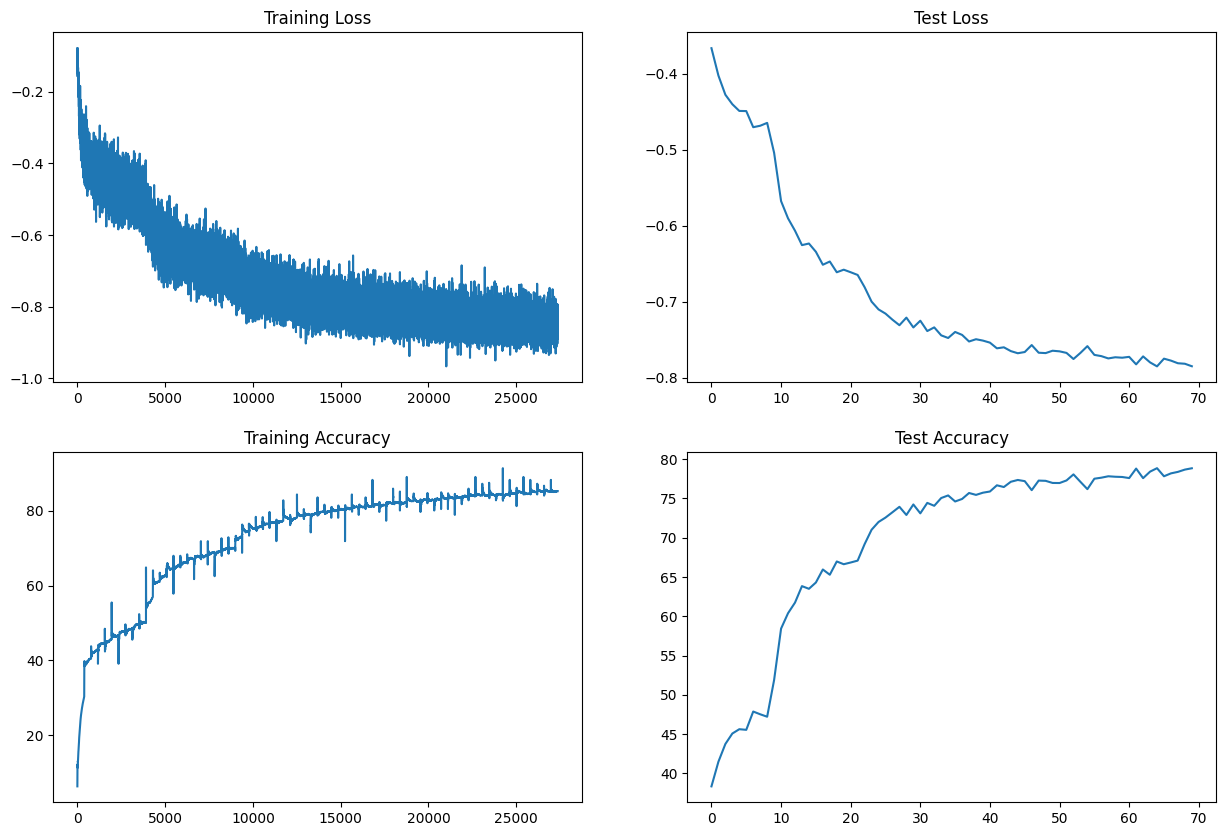

In [20]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [21]:
import torch.nn.functional as F
def get_incorrrect_predictions(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target, pred, output):
                if p.eq(t.view_as(p)).item() == False:
                    incorrect.append(
                        [d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])

    return incorrect


In [22]:
incorrect = get_incorrrect_predictions(model, test_loader, device)

In [23]:
def plot_incorrect_predictions(predictions, class_map, count=10):
    """Plot Incorrect predictions

    Args:
        predictions (list): List of all incorrect predictions
        class_map (dict): Lable mapping
        count (int, optional): Number of samples to print, multiple of 5. Defaults to 10.
    """
    print(f'Total Incorrect Predictions {len(predictions)}')

    if not count % 5 == 0:
        print("Count should be multiple of 10")
        return

    classes = list(class_map.keys())

    fig = plt.figure(figsize=(10, 5))
    for i, (d, t, p, o) in enumerate(predictions):
        ax = fig.add_subplot(int(count/5), 5, i + 1, xticks=[], yticks=[])
        ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}')
        show_image = d.cpu().numpy().transpose(1, 2, 0)
        # Rescale the pixel values to [0, 1]
        show_image = (show_image - np.min(show_image)) / (np.max(show_image) - np.min(show_image))
        plt.imshow(show_image)
        if i+1 == 5*(count/5):
            break

Total Incorrect Predictions 2114


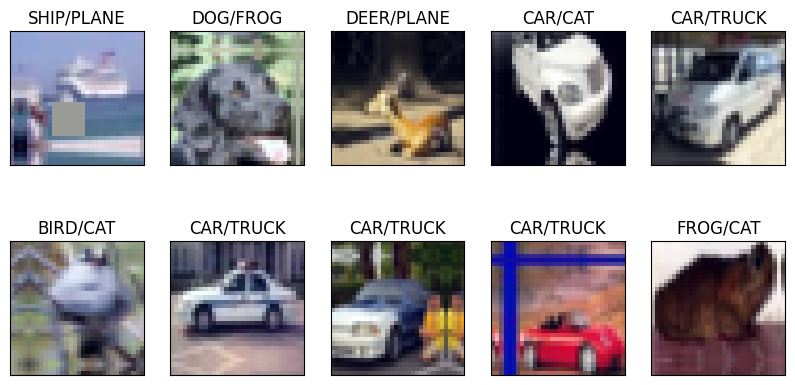

In [24]:
plot_incorrect_predictions(incorrect, class_map)